# RNN Example for Time Series

## Data

Data set: https://fred.stlouisfed.org/series/TRFVOLUSM227NFWA


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../Data/Miles_Traveled.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [4]:
df.head()

,TRFVOLUSM227NFWA
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


In [5]:
df.columns = ['Value']

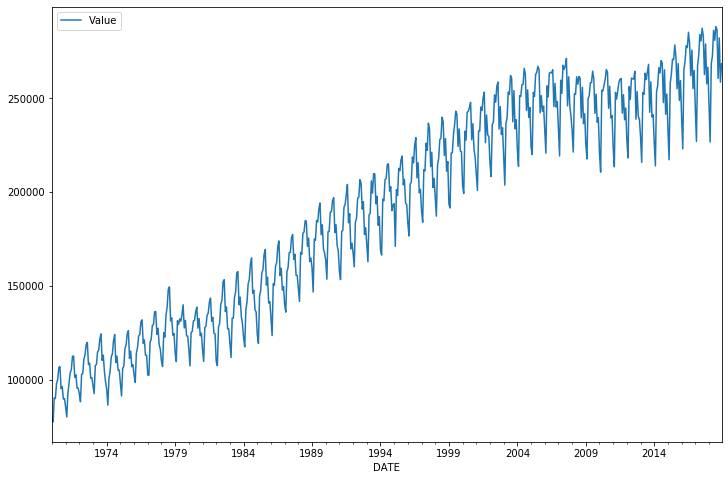

In [6]:
df.plot(figsize=(12,8))

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

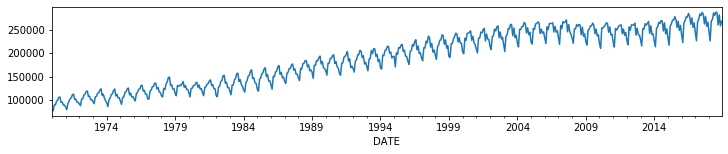

In [8]:
# Perform a Seasonal Decomposition on the model and plot out the ETS components
results = seasonal_decompose(df['Value'])
results.observed.plot(figsize=(12,2))

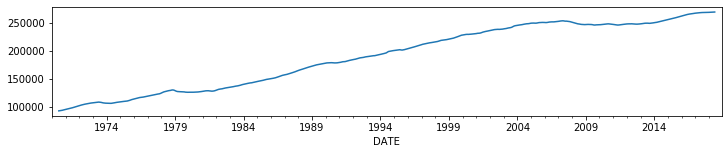

In [9]:
results.trend.plot(figsize=(12,2))

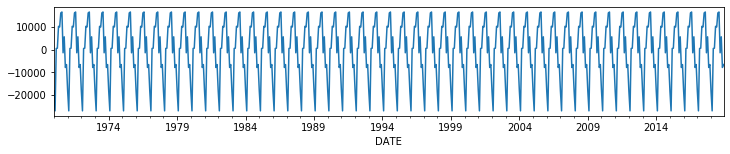

In [10]:
results.seasonal.plot(figsize=(12,2))

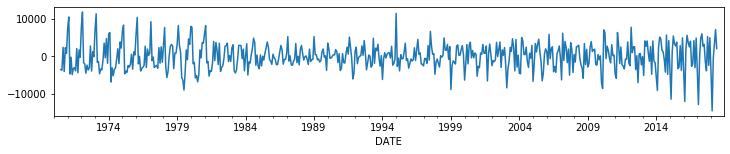

In [11]:
results.resid.plot(figsize=(12,2))

## Train Test Split

In [12]:
len(df)

588

In [13]:
# Split the data into a train/test split where the test set is the last 12 months of data.
train_len = len(df)-12
train = df.iloc[:train_len]
test = df.iloc[train_len:]

In [14]:
len(test)

12

## Scale Data

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

In [17]:
# Use a MinMaxScaler to scale the train and test sets into scaled versions.
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [18]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
# Create a TimeSeriesGenerator object based off the scaled_train data. 
# minimum n_input should be at least 12.
n_input = 24
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

### Create the Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
# define LSTM model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [24]:
earlystop_callback = EarlyStopping(monitor='loss', min_delta=0.0001,patience=2)
model.fit(generator,epochs=30, callbacks=[earlystop_callback])

  ...
    to  
  ['...']
Train for 552 steps
Epoch 1/30
552/552 [==============================] - 4s 7ms/step - loss: 0.0124
Epoch 2/30
552/552 [==============================] - 3s 6ms/step - loss: 0.0063
Epoch 3/30
552/552 [==============================] - 3s 6ms/step - loss: 0.0069
Epoch 4/30
552/552 [==============================] - 3s 6ms/step - loss: 0.0052
Epoch 5/30
552/552 [==============================] - 3s 6ms/step - loss: 0.0058
Epoch 6/30
552/552 [==============================] - 4s 6ms/step - loss: 0.0043
Epoch 7/30
552/552 [==============================] - 3s 6ms/step - loss: 0.0029
Epoch 8/30
552/552 [==============================] - 4s 6ms/step - loss: 0.0021
Epoch 9/30
552/552 [==============================] - 3s 6ms/step - loss: 0.0016
Epoch 10/30
552/552 [==============================] - 3s 6ms/step - loss: 0.0018
Epoch 11/30
552/552 [==============================] - 4s 6ms/step - loss: 0.0014
Epoch 12/30
552/552 [==============================] - 3s 6ms/

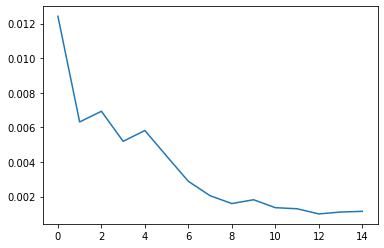

In [25]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Get Prediction of Test Data and Compare

In [26]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [27]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

In [29]:
test['Predictions'] = true_predictions

C:\Users\19792\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


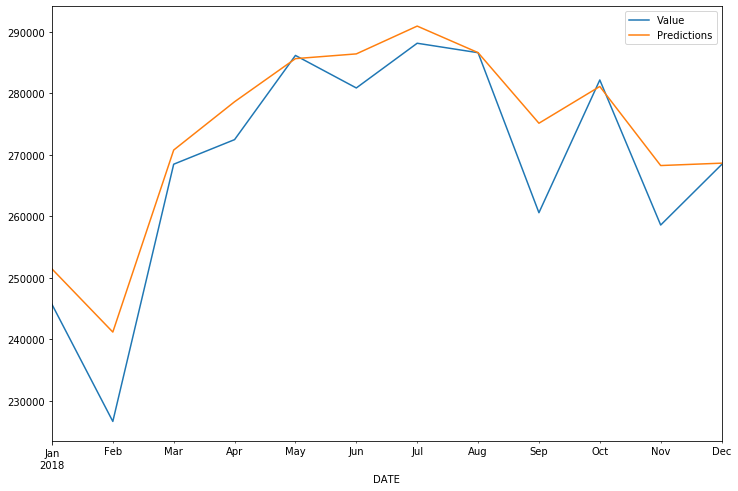

In [30]:
#Plot out the test set against the predicted values.
test.plot(figsize=(12,8))

In [32]:
model.save('solutions_model.h5')